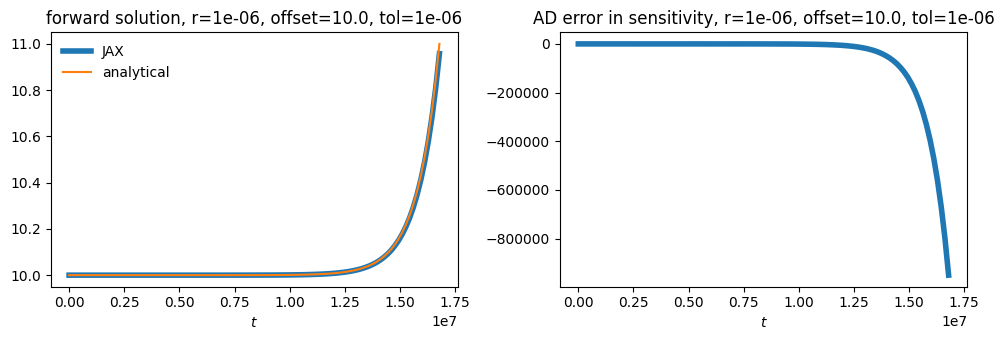

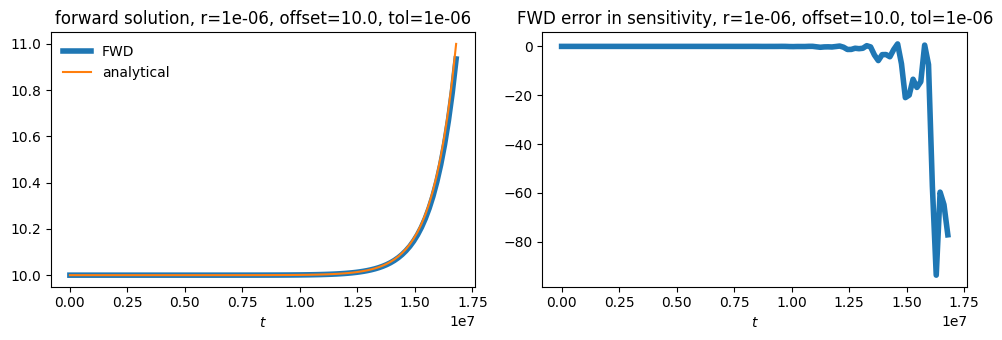

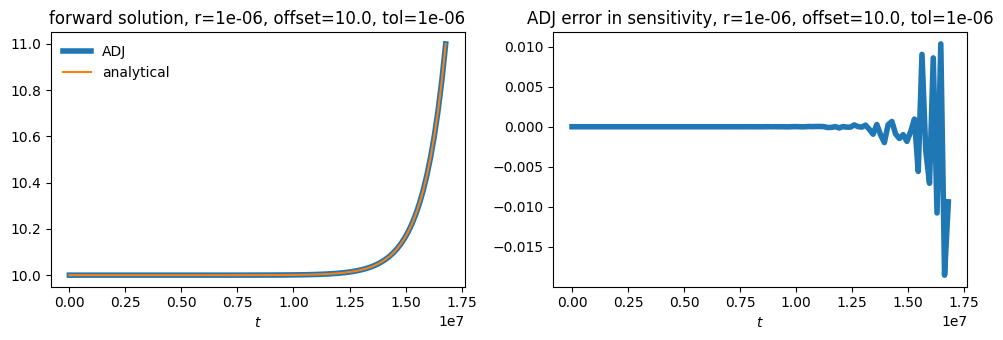

In [1]:
import numpy as np
import jax.numpy as jnp
import diffrax
import jax
from jax import grad, jacrev
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
jax.config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size':10})
import gc

offset = 1e1
r = 1e-6
tol = 1e-6
nn = 101
x0 = 1./19617869+offset
tSpan = jnp.linspace(0,1.0/np.abs(r)*np.log(1./(x0-offset)),nn)
gc.collect()

@jax.jit
def RHS(t,x,r):  
    return r*(x-offset)

@jax.jit
def xt(r):
    terms = diffrax.ODETerm(RHS)
    solver = diffrax.Dopri8()
    t0 = tSpan[0]
    t1 = tSpan[-1]
    dt0 = None
    IC = x0
    saveat = diffrax.SaveAt(ts=tSpan)
    stepsize_controller = diffrax.PIDController(rtol=tol, atol=tol)    
    sol = diffrax.diffeqsolve(terms,solver,t0,t1,dt0,IC,args=(r),saveat=saveat,stepsize_controller=stepsize_controller,max_steps=int(1e12))
    return sol.ys  

sensAD = jacrev(xt)(r)
solAD = xt(r)

fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(tSpan, solAD, lw=4, zorder = 1, label='JAX')
ax[0].plot(tSpan, (x0-offset)*np.exp(r*tSpan)+offset, zorder=3, label='analytical')
ax[0].legend(loc=2,frameon=False)
ax[0].set_xlabel('$t$')
ax[0].set_title(f'forward solution, r={r}, offset={offset}, tol={tol}')
ax[1].plot(tSpan, sensAD-(x0-offset)*tSpan*np.exp(r*tSpan),lw=4, zorder=111)
ax[1].set_xlabel('$t$')
ax[1].set_title(f'AD error in sensitivity, r={r}, offset={offset}, tol={tol}')
ax[1].set_yscale('linear')
plt.tight_layout()

import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
tSpan = np.array(tSpan)
par = r
x = x0
IC = state = np.array([x])

stateDim, parDim = 1, 1

@njit
def F(t,state,par):  
    x = state
    r = par
    return r*(x-offset)
        
@njit
def J(t,state,par):
    x = state
    r = par
    return r
    
@njit
def dFdtheta_constant(t,state,par):
    x = state
    r = par
    return x-offset
    
def jointF(t,jointState,par):
    x = jointState[:stateDim]
    s = jointState[stateDim:].reshape((stateDim,parDim))
    dx = F(t,x,par)
    ds = (J(t,x,par)*s+dFdtheta_constant(t,x,par)).reshape((stateDim*parDim,))
    return np.hstack((dx,ds))
    
jointState = np.zeros(stateDim*(parDim+1))
jointState[:stateDim] = np.array([x0])

sol_buffer = solve_ivp(fun=lambda t,z: jointF(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=jointState, t_eval=tSpan, method='DOP853', rtol=tol,atol=tol)
sensFWD = sol_buffer.y[1,:]
sol_buffer = solve_ivp(fun=lambda t,z: F(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=state, t_eval=tSpan, method='DOP853', rtol=tol,atol=tol)
solFWD = sol_buffer.y[0,:]

fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(tSpan, solFWD, lw=4, zorder = 1, label='FWD')
ax[0].plot(tSpan, (x0-offset)*np.exp(r*tSpan)+offset, zorder=3, label='analytical')
ax[0].legend(loc=2,frameon=False)
ax[0].set_xlabel('$t$')
ax[0].set_title(f'forward solution, r={r}, offset={offset}, tol={tol}')
ax[1].plot(tSpan, sensFWD-(x0-offset)*tSpan*np.exp(r*tSpan),lw=4, zorder=111)
ax[1].set_xlabel('$t$')
ax[1].set_title(f'FWD error in sensitivity, r={r}, offset={offset}, tol={tol}')
ax[1].set_yscale('linear')
plt.tight_layout()

@njit
def F(t,state,par):  
    x = state
    r = par
    return r*(x-offset)
        
@njit
def J(t,state,par):
    x = state
    r = par
    return r
    
@njit
def dFdtheta_constant(t,state,par):
    x = state
    r = par
    return x-offset
    
def jointBackward(t,jointState,par):
    xx = jointState[:stateDim]
    adj = jointState[stateDim:2*stateDim]
    dx = F(t,xx,par).reshape((stateDim,))
    dadj = -(adj.reshape([1,stateDim]).dot(J(t,xx,par))).reshape((stateDim,))
    dsens = -(adj.reshape([1,stateDim]).dot(dFdtheta_constant(t,xx,par))).reshape((parDim,))
    return np.hstack((dx, dadj, dsens))
    
def forwardSimulation(par):
    state = np.copy(IC)
    sol_buffer = solve_ivp(fun=lambda t,z: F(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=state, t_eval=tSpan, method='DOP853', rtol=tol,atol=tol)
    return sol_buffer.t, sol_buffer.y

def analyticalSolution(tSpan,par):
    r = par
    return tSpan,((x0-offset)*np.exp(r*tSpan)+offset).reshape([1, len(tSpan)])
   
def adjointSensitivities(par):
    t,fullState = analyticalSolution(tSpan,par)
    nn = len(tSpan)
    temp1 = fullState[0]
    temp2 = np.zeros(nn)
 
    for idx in range(1,nn+1):
        jointState = np.zeros(2*stateDim+parDim)
        jointState[stateDim:2*stateDim] = 1
       
        for i in range(nn-idx):
            jointState[:stateDim] = fullState[:,-idx-i]
            sol_buffer = solve_ivp(fun=lambda t,z: jointBackward(t,z,par), t_span=(tSpan[[-1-i,-2-i]]),y0=jointState, t_eval=tSpan[::-1][i:i+2], method='DOP853',rtol=tol,atol=tol)
            jointState[:] = sol_buffer.y[:,1]
        temp2[idx-1] = jointState[2*stateDim]
 
    return temp1, temp2

solADJ, sensADJ = adjointSensitivities(par)
    
fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(tSpan, solADJ, lw=4, zorder = 1, label='ADJ')
ax[0].plot(tSpan, (x0-offset)*np.exp(r*tSpan)+offset, zorder=3, label='analytical')
ax[0].legend(loc=2,frameon=False)
ax[0].set_xlabel('$t$')
ax[0].set_title(f'forward solution, r={r}, offset={offset}, tol={tol}')
ax[1].plot(tSpan, sensADJ[::-1]-(x0-offset)*tSpan*np.exp(r*tSpan),lw=4, zorder=111)
ax[1].set_xlabel('$t$')
ax[1].set_title(f'ADJ error in sensitivity, r={r}, offset={offset}, tol={tol}')
ax[1].set_yscale('linear')
plt.tight_layout()

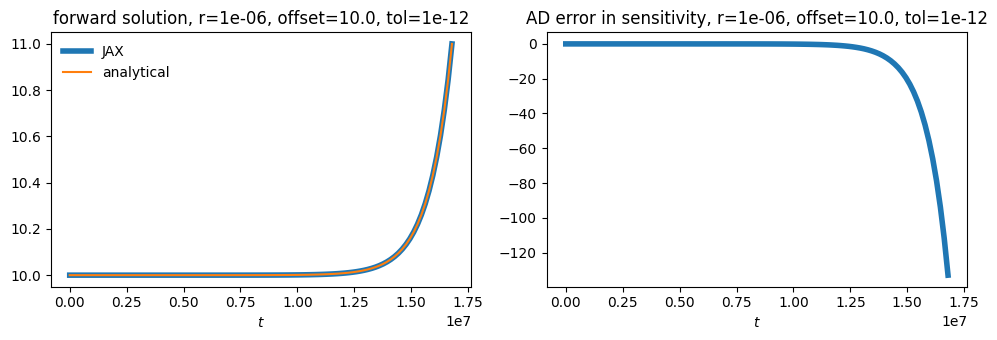

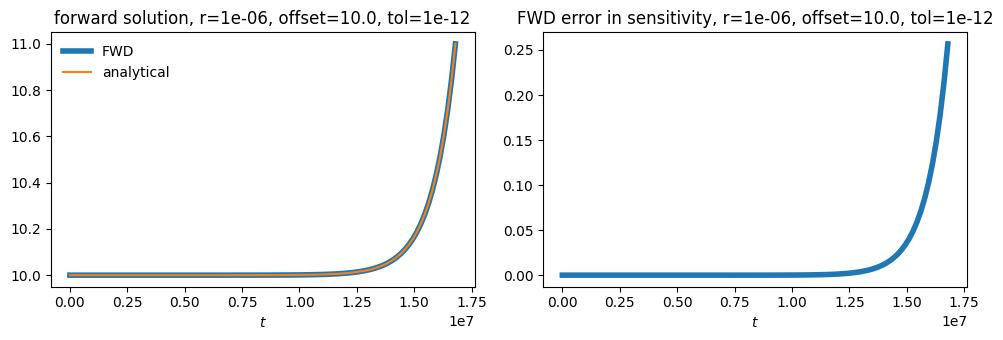

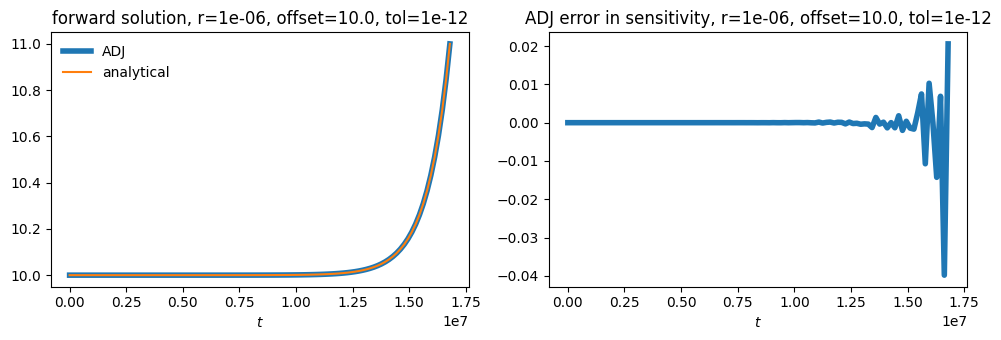

In [2]:
import numpy as np
import jax.numpy as jnp
import diffrax
import jax
from jax import grad, jacrev
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
jax.config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size':10})
import gc

offset = 1e1
r = 1e-6
tol = 1e-12
nn = 101
x0 = 1./19617869+offset
tSpan = jnp.linspace(0,1.0/np.abs(r)*np.log(1./(x0-offset)),nn)
gc.collect()

@jax.jit
def RHS(t,x,r):  
    return r*(x-offset)

@jax.jit
def xt(r):
    terms = diffrax.ODETerm(RHS)
    solver = diffrax.Dopri8()
    t0 = tSpan[0]
    t1 = tSpan[-1]
    dt0 = None
    IC = x0
    saveat = diffrax.SaveAt(ts=tSpan)
    stepsize_controller = diffrax.PIDController(rtol=tol, atol=tol)    
    sol = diffrax.diffeqsolve(terms,solver,t0,t1,dt0,IC,args=(r),saveat=saveat,stepsize_controller=stepsize_controller,max_steps=int(1e12))
    return sol.ys  

sensAD = jacrev(xt)(r)
solAD = xt(r)

fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(tSpan, solAD, lw=4, zorder = 1, label='JAX')
ax[0].plot(tSpan, (x0-offset)*np.exp(r*tSpan)+offset, zorder=3, label='analytical')
ax[0].legend(loc=2,frameon=False)
ax[0].set_xlabel('$t$')
ax[0].set_title(f'forward solution, r={r}, offset={offset}, tol={tol}')
ax[1].plot(tSpan, sensAD-(x0-offset)*tSpan*np.exp(r*tSpan),lw=4, zorder=111)
ax[1].set_xlabel('$t$')
ax[1].set_title(f'AD error in sensitivity, r={r}, offset={offset}, tol={tol}')
ax[1].set_yscale('linear')
plt.tight_layout()

import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
tSpan = np.array(tSpan)
par = r
x = x0
IC = state = np.array([x])

stateDim, parDim = 1, 1

@njit
def F(t,state,par):  
    x = state
    r = par
    return r*(x-offset)
        
@njit
def J(t,state,par):
    x = state
    r = par
    return r
    
@njit
def dFdtheta_constant(t,state,par):
    x = state
    r = par
    return x-offset
    
def jointF(t,jointState,par):
    x = jointState[:stateDim]
    s = jointState[stateDim:].reshape((stateDim,parDim))
    dx = F(t,x,par)
    ds = (J(t,x,par)*s+dFdtheta_constant(t,x,par)).reshape((stateDim*parDim,))
    return np.hstack((dx,ds))
    
jointState = np.zeros(stateDim*(parDim+1))
jointState[:stateDim] = np.array([x0])

sol_buffer = solve_ivp(fun=lambda t,z: jointF(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=jointState, t_eval=tSpan, method='DOP853', rtol=tol,atol=tol)
sensFWD = sol_buffer.y[1,:]
sol_buffer = solve_ivp(fun=lambda t,z: F(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=state, t_eval=tSpan, method='DOP853', rtol=tol,atol=tol)
solFWD = sol_buffer.y[0,:]

fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(tSpan, solFWD, lw=4, zorder = 1, label='FWD')
ax[0].plot(tSpan, (x0-offset)*np.exp(r*tSpan)+offset, zorder=3, label='analytical')
ax[0].legend(loc=2,frameon=False)
ax[0].set_xlabel('$t$')
ax[0].set_title(f'forward solution, r={r}, offset={offset}, tol={tol}')
ax[1].plot(tSpan, sensFWD-(x0-offset)*tSpan*np.exp(r*tSpan),lw=4, zorder=111)
ax[1].set_xlabel('$t$')
ax[1].set_title(f'FWD error in sensitivity, r={r}, offset={offset}, tol={tol}')
ax[1].set_yscale('linear')
plt.tight_layout()

@njit
def F(t,state,par):  
    x = state
    r = par
    return r*(x-offset)
        
@njit
def J(t,state,par):
    x = state
    r = par
    return r
    
@njit
def dFdtheta_constant(t,state,par):
    x = state
    r = par
    return x-offset
    
def jointBackward(t,jointState,par):
    xx = jointState[:stateDim]
    adj = jointState[stateDim:2*stateDim]
    dx = F(t,xx,par).reshape((stateDim,))
    dadj = -(adj.reshape([1,stateDim]).dot(J(t,xx,par))).reshape((stateDim,))
    dsens = -(adj.reshape([1,stateDim]).dot(dFdtheta_constant(t,xx,par))).reshape((parDim,))
    return np.hstack((dx, dadj, dsens))
    
def forwardSimulation(par):
    state = np.copy(IC)
    sol_buffer = solve_ivp(fun=lambda t,z: F(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=state, t_eval=tSpan, method='DOP853', rtol=tol,atol=tol)
    return sol_buffer.t, sol_buffer.y

def analyticalSolution(tSpan,par):
    r = par
    return tSpan,((x0-offset)*np.exp(r*tSpan)+offset).reshape([1, len(tSpan)])
   
def adjointSensitivities(par):
    t,fullState = analyticalSolution(tSpan,par)
    nn = len(tSpan)
    temp1 = fullState[0]
    temp2 = np.zeros(nn)
 
    for idx in range(1,nn+1):
        jointState = np.zeros(2*stateDim+parDim)
        jointState[stateDim:2*stateDim] = 1
       
        for i in range(nn-idx):
            jointState[:stateDim] = fullState[:,-idx-i]
            sol_buffer = solve_ivp(fun=lambda t,z: jointBackward(t,z,par), t_span=(tSpan[[-1-i,-2-i]]),y0=jointState, t_eval=tSpan[::-1][i:i+2], method='DOP853',rtol=tol,atol=tol)
            jointState[:] = sol_buffer.y[:,1]
        temp2[idx-1] = jointState[2*stateDim]
 
    return temp1, temp2

solADJ, sensADJ = adjointSensitivities(par)
    
fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(tSpan, solADJ, lw=4, zorder = 1, label='ADJ')
ax[0].plot(tSpan, (x0-offset)*np.exp(r*tSpan)+offset, zorder=3, label='analytical')
ax[0].legend(loc=2,frameon=False)
ax[0].set_xlabel('$t$')
ax[0].set_title(f'forward solution, r={r}, offset={offset}, tol={tol}')
ax[1].plot(tSpan, sensADJ[::-1]-(x0-offset)*tSpan*np.exp(r*tSpan),lw=4, zorder=111)
ax[1].set_xlabel('$t$')
ax[1].set_title(f'ADJ error in sensitivity, r={r}, offset={offset}, tol={tol}')
ax[1].set_yscale('linear')
plt.tight_layout()